# <center>**Images**<center>

**Libraries**

In [37]:
import numpy as np
from scipy.signal import correlate

import maskpattern as mp
import plot_module as plot
import balancing as bal
import stats
import iros as sk

np.set_printoptions(precision=2, suppress=False)

**Mask and Decoder**

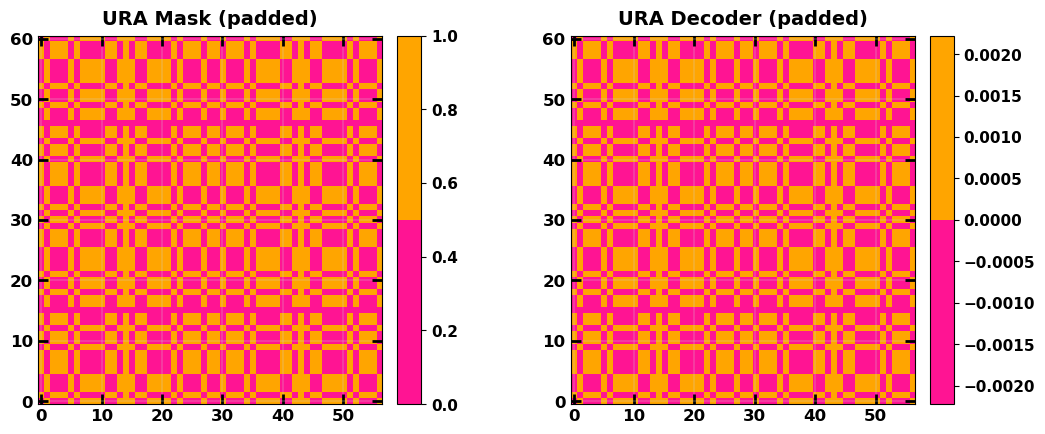

In [3]:
ura = mp.URAMaskPattern(4)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["URA Mask (padded)", "URA Decoder (padded)"])

**Images Dimension**

In [4]:
bulk_array_shape = ura_pattern2D.shape    # detector shape == basic pattern
sky_shape = (3*n - 2, 3*m - 2)             # sky shape (FCFOV + PCFOV) == M + D - 1

**Detector**

In [8]:
bulk_array = np.ones(bulk_array_shape)
bulk_array = np.pad(bulk_array, ((n - 1, n - 1), (m - 1, m - 1)))

assert bulk_array.shape == sky_shape

**Sky Image**

In [15]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    # generate sky
    if sky_background_rate is not None:
        sky_image = np.random.poisson(sky_background_rate, sky_image_shape)
    else:
        sky_image = np.zeros(sky_image_shape)
    
    sky_background = sky_image.copy()

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]
    
    return sky_image, sky_background, sources_pos

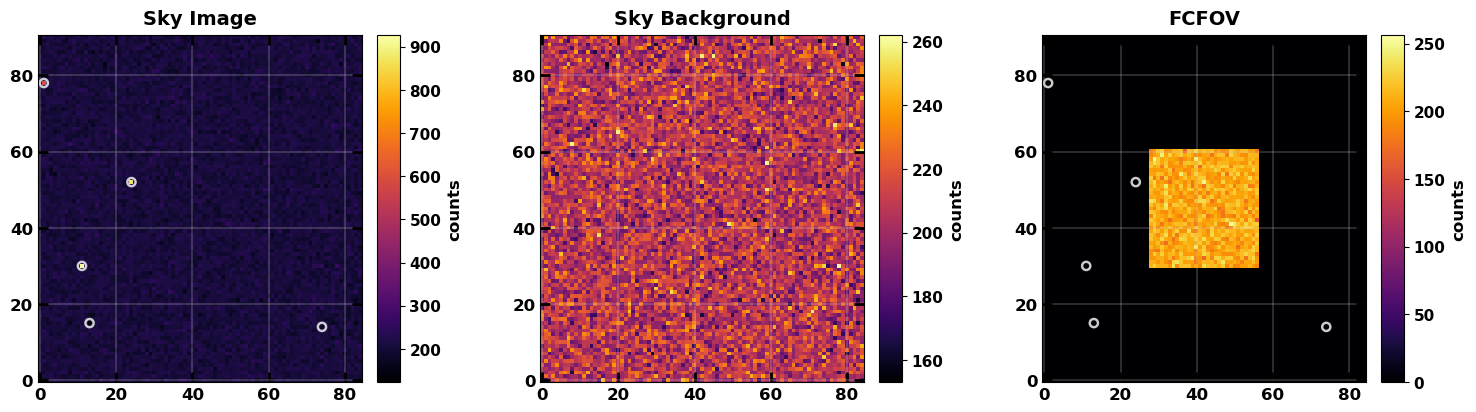

In [19]:
sources_flux = np.random.randint(50, 1000, size=5)
sources_pos = None
sky_background_rate = sources_flux.min() + np.random.randint(0, sources_flux.min())

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)
sky_significance = stats.significance(sky_image, sky_background_rate)

plot.image_plot([sky_image, sky_background, sky_image*bulk_array],
                ["Sky Image", "Sky Background", "FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, None, sources_pos])

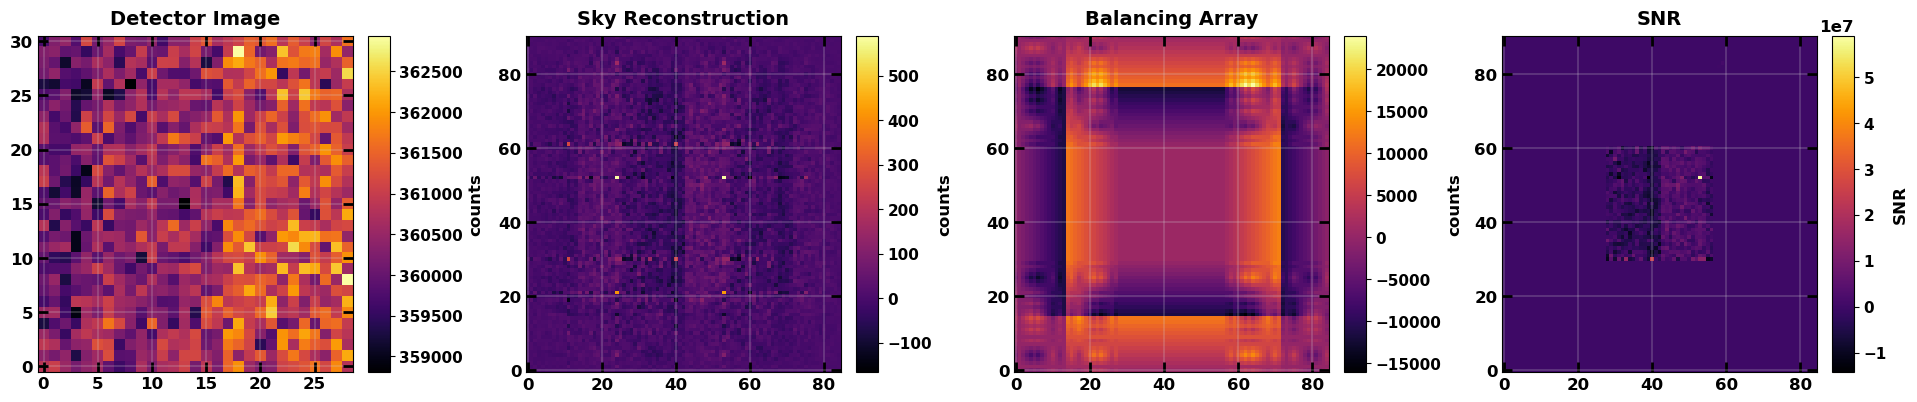

In [40]:
detector_image = correlate(mask, sky_image, mode='valid')

b = np.ones(bulk_array_shape)
bal = correlate(decoder, b*(detector_image.sum()/b.sum()))
sky_reconstruction = correlate(decoder, detector_image) - bal

snr = np.nan_to_num(sky_reconstruction/(correlate(decoder**2, detector_image) - correlate(decoder**2, b*(detector_image.sum()/b.sum())) + 1e-5))


plot.image_plot([detector_image, sky_reconstruction, bal, snr],
                ["Detector Image", "Sky Reconstruction", "Balancing Array", "SNR"],
                cbarlabel=["counts"]*3 + ["SNR"], 
                cbarcmap=["inferno"]*4)

In [ ]:


iros = sk.IROS(
    n_iter=len(sources_flux) + 6,
    snr_threshold=5,
    skyrec=sky_reconstruction,
    skyrec_snr=snr,
    detector_image=detector_image,
    source_pos=sources_pos,
    balancing_skyrec=balancing,
    vis_thres=3000)

sources_dataset, iros_skyrec, iros_snr = iros.iterate(
    check_snr_norm=True,
    show_peaks=True,
    show_results=True)